In [5]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [17]:
DATA_PATH = ''
HISTORY_PATH = "Voter_History_{0}"
REGISTRATION_PATH = "data/{0}_VoterDetail"
COUNTY="DAD"

In [49]:
date_str = '20140319'

In [14]:
def get_county_files():
    registration_path = REGISTRATION_PATH.format(str(date))
    county_files = []
    for f in listdir(registration_path):
        if isfile(registration_path + "/" + f):
            county_files.append(registration_path + "/" + f)
    return county_files

In [15]:
county_files = get_county_files()

In [18]:
largest_county = './'+COUNTY+'_'+date+'.txt'

In [64]:
registration_file_headers = [
    'county_code',
    'voter_id',
    'last_name',
    'suffix',
    'first_name',
    'middle_name',
    'requested_public_records_exemption',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city',
    'residence_state',
    'residence_zipcode',
    'mail_addr_line_1',
    'mail_addr_line_2',
    'mail_addr_line_3',
    'mail_city',
    'mail_state',
    'mail_zipcode',
    'mail_country',
    'gender',
    'race',
    'birth_date',
    'registration_date',
    'party_affiliation',
    'precinct',
    'precinct_group',
    'precinct_split',
    'precinct_suffix',
    'voter_status',
    'congressional_district',
    'house_district',
    'senate_district',
    'county_commission_district',
    'school_board_district',
    'daytime_area_code',
    'daytime_phone_no',
    'daytime_phone_extension',
    'email_address'
]
selective_headers = [
    'first_name',
    'last_name',
    'birth_date',
    'county_code',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city',
    'residence_zipcode',
    'gender',
    'race',
    'registration_date',
    'precinct',
    'voter_id',
    'party_affiliation',
    'voter_status'
]

In [94]:
global_df = pd.read_csv( REGISTRATION_PATH.format(date_str) + "/" + largest_county, sep='\t', names=registration_file_headers, usecols=selective_headers)

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [95]:
global_df.isnull().sum()

county_code                 0
voter_id                    0
last_name                   0
first_name                  1
residence_addr_line_1       0
residence_addr_line_2       0
residence_city              0
residence_zipcode           0
gender                      2
race                        0
birth_date               1738
registration_date           0
party_affiliation           0
precinct                    1
voter_status                0
dtype: int64

In [97]:
req_cols = ['residence_city', 'gender', 'birth_date', 'precinct', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [98]:
global_df.isnull().sum()

county_code              0
voter_id                 0
last_name                0
first_name               0
residence_addr_line_1    0
residence_addr_line_2    0
residence_city           0
residence_zipcode        0
gender                   0
race                     0
birth_date               0
registration_date        0
party_affiliation        0
precinct                 0
voter_status             0
dtype: int64

In [99]:
global_df.shape

(1367975, 15)

In [100]:
from datetime import datetime
from datetime import date

def calculate_age(born):
    born = datetime.strptime(str(born), "%m/%d/%Y").date()
    today = datetime.strptime("08/13/2019", "%m/%d/%Y").date()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

global_df['age'] = global_df['birth_date'].apply(calculate_age)

In [101]:
global_df.head()

,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age
0,DAD,100012467,Brummitt,Marilyn,421 NW 150Th ST,,Miami,33168,F,5,04/12/1950,11/05/1975,REP,131.0,ACT,69
1,DAD,100014823,Westervelt,Erna,11041 SW 124Th ST,,Miami,33176,F,5,01/16/1923,02/10/1972,REP,756.0,ACT,96
2,DAD,100021401,Chang,Zoila,11047 NW 3Rd TER,,Sweetwater,33172,F,5,06/27/1946,01/21/1976,REP,410.0,ACT,73
3,DAD,100021484,Harris,Roberta,15605 SW 57Th LN,,Miami,33193,F,5,05/22/1938,01/23/1976,REP,764.0,ACT,81
4,DAD,100024033,Guillermety,Carmen,10951 SW 161St PL,,Miami,33196,F,5,12/28/1916,08/02/1976,REP,766.0,ACT,102


In [102]:
str_cols_lower = [
    'last_name',
    'first_name',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city'
]
str_cols_upper = [
    'county_code',
    'gender',
    'party_affiliation',
    'voter_status'
]

In [103]:
for col in str_cols_lower:
    global_df[col] = global_df[col].apply(lambda x: str(x).strip().lower())
for col in str_cols_upper:
    global_df[col] = global_df[col].apply(lambda x: str(x).strip().upper())

In [104]:
global_df['residence_zipcode_5'] = global_df['residence_zipcode'].apply(lambda x: int(str(x)[:5]))

In [105]:
def generate_zipcode_4(zip):
    zip = str(zip)
    if len(zip) > 5:
        return int(zip[-4:])
    else:
        return ''

global_df['residence_zipcode_4'] = global_df['residence_zipcode'].apply(generate_zipcode_4)

In [106]:
global_df['uniq_addr'] = global_df[['residence_addr_line_1', 'residence_addr_line_2', 'residence_city', 'residence_zipcode_5']].apply(lambda x: ' '.join([str(y) for y in x]), axis=1)

In [107]:
import re
global_df['uniq_addr'] = global_df['uniq_addr'].apply(lambda x: re.sub("[^0-9a-zA-Z\s]+", '', x))

In [108]:
global_df['uniq_addr'] = global_df['uniq_addr'].apply(lambda x: x.strip())

In [109]:
global_df['uniq_addr'].head()

0          421  nw 150th st  miami 33168
1        11041  sw 124th st  miami 33176
2    11047  nw 3rd ter  sweetwater 33172
3         15605  sw 57th ln  miami 33193
4        10951  sw 161st pl  miami 33196
Name: uniq_addr, dtype: object

In [110]:
aggregated_df = global_df.groupby(['uniq_addr', 'last_name'])['last_name'].agg(['count']).reset_index()
# aggregated_df.columns = [' '.join(col).strip() for col in aggregated_df.columns.values]

In [111]:
aggregated_df = aggregated_df.rename(columns={"count": "member_count"})

In [112]:
global_df = pd.merge(global_df, aggregated_df, on=['uniq_addr', 'last_name'], how='inner')

In [113]:
global_df.head()

,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr,member_count
0,DAD,100012467,brummitt,marilyn,421 nw 150th st,,miami,33168,F,5,04/12/1950,11/05/1975,REP,131.0,ACT,69,33168,,421 nw 150th st miami 33168,1
1,DAD,100014823,westervelt,erna,11041 sw 124th st,,miami,33176,F,5,01/16/1923,02/10/1972,REP,756.0,ACT,96,33176,,11041 sw 124th st miami 33176,1
2,DAD,100021401,chang,zoila,11047 nw 3rd ter,,sweetwater,33172,F,5,06/27/1946,01/21/1976,REP,410.0,ACT,73,33172,,11047 nw 3rd ter sweetwater 33172,1
3,DAD,100021484,harris,roberta,15605 sw 57th ln,,miami,33193,F,5,05/22/1938,01/23/1976,REP,764.0,ACT,81,33193,,15605 sw 57th ln miami 33193,1
4,DAD,100024033,guillermety,carmen,10951 sw 161st pl,,miami,33196,F,5,12/28/1916,08/02/1976,REP,766.0,ACT,102,33196,,10951 sw 161st pl miami 33196,2


In [114]:
house_size_2 = global_df[global_df['member_count'] == 2]

In [115]:
male_df = house_size_2[house_size_2['gender'] == 'M']

In [116]:
female_df = house_size_2[house_size_2['gender'] == 'F']

In [117]:
temp = pd.merge(male_df, female_df, on=['uniq_addr', 'last_name'], how='inner', suffixes=('_male', '_female'))

In [118]:
lower_age_threshold = 30
age_diff_threshold = 20

In [119]:
def couple_heuristic(row):
    age_diff = abs(row['age_male'] - row['age_female'])
    if row['age_male'] >= lower_age_threshold and row['age_female'] >= lower_age_threshold and age_diff <= age_diff_threshold:
        return True
    return False
        

In [120]:
couples = temp[temp.apply(couple_heuristic, axis=1)]

In [121]:
polarized_couples = couples[couples['party_affiliation_male'] != couples['party_affiliation_female']]

In [122]:
couples.to_csv('all_couples_20190813.csv', sep='\t')

In [123]:
polarized_couples.to_csv('polarized_couples_20190813.csv', sep='\t')

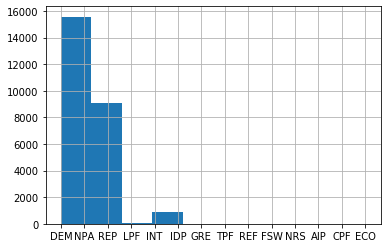

In [124]:
polarized_couples['party_affiliation_male'].hist()

In [125]:
type(polarized_couples)

pandas.core.frame.DataFrame

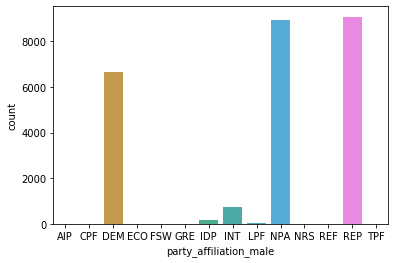

In [126]:
figs, axes = plt.subplots(nrows=1, ncols=1)
sns.barplot(x='party_affiliation_male', y='count', data=polarized_couples.groupby(['party_affiliation_male'])['first_name_male'].agg(['count']).reset_index())

In [133]:
global_df.shape

(1367975, 20)

In [128]:
global_df.head()

,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr,member_count
0,DAD,100012467,brummitt,marilyn,421 nw 150th st,,miami,33168,F,5,04/12/1950,11/05/1975,REP,131.0,ACT,69,33168,,421 nw 150th st miami 33168,1
1,DAD,100014823,westervelt,erna,11041 sw 124th st,,miami,33176,F,5,01/16/1923,02/10/1972,REP,756.0,ACT,96,33176,,11041 sw 124th st miami 33176,1
2,DAD,100021401,chang,zoila,11047 nw 3rd ter,,sweetwater,33172,F,5,06/27/1946,01/21/1976,REP,410.0,ACT,73,33172,,11047 nw 3rd ter sweetwater 33172,1
3,DAD,100021484,harris,roberta,15605 sw 57th ln,,miami,33193,F,5,05/22/1938,01/23/1976,REP,764.0,ACT,81,33193,,15605 sw 57th ln miami 33193,1
4,DAD,100024033,guillermety,carmen,10951 sw 161st pl,,miami,33196,F,5,12/28/1916,08/02/1976,REP,766.0,ACT,102,33196,,10951 sw 161st pl miami 33196,2


In [129]:
aggregated_df.head()

,uniq_addr,last_name,member_count
0,1 adams ky islandia 33035,stephens,1
1,1 alhambra cir coral gables 33134,calvillo,1
2,1 alhambra cir 205 coral gables 33134,yngerto,1
3,1 alhambra cir 302 coral gables 33134,menendez palacios,1
4,1 alhambra cir 303 coral gables 33134,morales,1


In [130]:
# global_df['uniq_addr'] = global_df[[]]

In [131]:
last_name_counts = global_df.last_name.value_counts().to_dict()
last_names = set([name for name in last_name_counts if last_name_counts[name] > 1])

In [132]:
aggregated_df = global_df.groupby(['uniq_addr', 'last_name']).agg(['count']).reset_index()
aggregated_df.columns = [' '.join(col).strip() for col in aggregated_df.columns.values]

In [154]:
aggregated_df.head()

,uniq_addr,last_name,county_code count,voter_id count,first_name count,middle_name count,residence_addr_line_1 count,residence_addr_line_2 count,residence_city count,residence_state count,...,race count,birth_date count,registration_date count,party_affiliation count,precinct count,voter_status count,email_address count,age count,residence_zipcode_5 count,residence_zipcode_4 count
0,1 alhambra cir 201 coral gables 33134,gonzalez del campo,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1 alhambra cir 303 coral gables 33134,morales,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1 alhambra cir 306 coral gables 33134,hevia,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1 alhambra cir 405 coral gables 33134,paul,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1 alhambra cir 406 coral gables 33134,salup mosquera,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [155]:
aggregated_df[aggregated_df['first_name count'] == 1].shape

(633397, 22)

In [156]:
global_df.shape

(941446, 22)

In [88]:
lower_age_threshold = 30
upper_age_threshold = 50
global_df = global_df[(global_df['age'] >= lower_age_threshold) & (global_df['age'] <= upper_age_threshold)]

In [89]:
sibling_age_threshold = 30

In [90]:
global_df.shape

(503667, 17)

In [91]:
temp = global_df.groupby(['last_name', 'residence_addr_line_1', 'residence_city', 'residence_zipcode']).agg(['count']).reset_index()

In [92]:
temp.columns = [' '.join(col).strip() for col in temp.columns.values]

In [93]:
temp.columns

Index(['last_name', 'residence_addr_line_1', 'residence_city',
       'residence_zipcode', 'county_code count', 'voter_id count',
       'first_name count', 'residence_addr_line_2 count',
       'residence_state count', 'gender count', 'race count',
       'birth_date count', 'registration_date count',
       'party_affiliation count', 'precinct count', 'voter_status count',
       'age count'],
      dtype='object')

In [94]:
temp[temp['first_name count'] == 1].shape

(438946, 17)

In [95]:
temp.shape

(470610, 17)

In [98]:
global_df[global_df['residence_addr_line_1'] == ''].shape

(0, 17)

In [179]:
# c = pd.DataFrame({"c": global_df['residence_addr_line_1'].apply(lambda x: re.sub("[^0-9a-zA-Z\s]+", '', x))})

(89508, 2)

(142846, 2)

In [160]:
t1 = global_df['last_name'].value_counts()

In [164]:
a = global_df.groupby(['last_name'])['last_name'].agg(['count']).reset_index()

In [168]:
a.shape

(142846, 2)

In [176]:
a[a['count'] > 1].shape

(53338, 2)

In [170]:
b = global_df.groupby(['residence_addr_line_1'])['residence_addr_line_1'].agg(['count']).reset_index()

In [171]:
b.head()

,residence_addr_line_1,count
0,1 alhambra cir,31
1,1 andalusia ave,139
2,1 arvida pkwy,2
3,1 casuarina concourse,1
4,1 century ln,32


In [172]:
b.sort_values(by='count', ascending=False)

,residence_addr_line_1,count
204996,2700 nw 87th ave,2920
205042,2700 d nw 87th ave,1310
52301,1231 dickinson dr,454
164258,19800 sw 180th ave,440
155095,1900 n bayshore dr,424
...,...,...
176865,2111 ne 210th st,1
176868,2111 ne 212th st,1
176869,2111 ne 37th rd,1
176871,2111 ne 40th ave,1


In [173]:
b[b['count'] == 1].shape

(169775, 2)

In [159]:
global_df['residence_addr_line_1'].value_counts()

2700  nw 87th ave  doral 33172                 2919
2700 d nw 87th ave  doral 33172                1306
2700 c nw 87th ave  doral 33172                 420
2700 f nw 87th ave  doral 33172                 412
15800  nw 42nd ave  miami gardens 33054         300
                                               ... 
701   swan ave  miami springs 33166               1
1017  nw 132nd ave w  miami 33182                 1
7929   west dr apt 1002 n bay village 33141       1
13218  nw 4th ter  miami 33182                    1
7730   camino real f108 miami 33143               1
Name: uniq_addr, Length: 584212, dtype: int64

In [174]:
b.shape

(376643, 2)